In [1]:
import tsai
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.JPIJNSWNNAN3CE6LLI5FWSPHUT2VXMTH.gfortran-win_amd64.dll
C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


tsai       : 0.2.15
fastai     : 2.2.5
fastcore   : 1.3.19
torch      : 1.7.1+cu101


# 0. load data

In [2]:
input_fn = 'F:\\Github\\kaggle drought\\data_ndarray.npz'

In [3]:
data = np.load(open(input_fn, 'rb'))

In [4]:
X_train = data['X_train']

In [5]:
X_train.shape

(118024, 90, 18)

In [6]:
print(np.mean(X_train.flatten()))

1.1619668e-07


In [7]:
print(np.std(X_train.flatten()))

1.0000005


In [8]:
X_valid = data['X_valid']

In [9]:
X_test = data['X_test']

In [10]:
y_train = data['y_train']
y_train = np.array([int(i) for i in y_train])

In [11]:
y_valid = data['y_valid']
y_valid = np.array([int(i) for i in y_valid])

In [12]:
y_test = data['y_test']
y_test = np.array([int(i) for i in y_test])

We need to exchange two axes：
* **number of samples**
* **number of features** (aka variables, dimensions, channels)
* **number of steps** (or length, time steps, sequence steps)

In [13]:
X_train = X_train.transpose(0, 2, 1)
X_train.shape

(118024, 18, 90)

In [14]:
X_valid = X_valid.transpose(0, 2, 1)
X_valid.shape

(20721, 18, 90)

In [15]:
X_test = X_test.transpose(0, 2, 1)
X_test.shape

(102430, 18, 90)

We already have the split:

In [16]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [17]:
X.shape

(138745, 18, 90)

In [18]:
y.shape

(138745,)

In [19]:
splits

((#118024) [0,1,2,3,4,5,6,7,8,9...],
 (#20721) [118024,118025,118026,118027,118028,118029,118030,118031,118032,118033...])

In [20]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dsets

(#138745) [(TSTensor(vars:18, len:90), TensorCategory(2, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(1, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(2, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(1, dtype=torch.int32))...]

# 1. Model and Hyperparameter Tuning

In [21]:
import hyperopt
print(hyperopt.__version__)

0.2.5


In [22]:
from hyperopt import Trials, STATUS_OK, STATUS_FAIL, tpe, fmin, hp

In [23]:
search_space = {
    'batch_size': hp.choice('bs', [256, 512, 1024]),
    'time_steps': hp.choice('ts', [30, 60, 90]),  # lookback window size
    "lr": hp.choice('lr', [0.1, 0.01, 0.001, 0.0001]),
    "epochs": hp.choice('epochs', [10, 50, 100]),  # we would also use early stopping
    "patience": hp.choice('patience', [5, 10]),  # early stopping patience
    "optimizer": hp.choice('optimizer', [Adam, SGD, RMSProp]),  # https://docs.fast.ai/optimizer
    # model parameters
    "n_layers": hp.choice('n_layers', [1, 2, 3, 4, 5]),
    "hidden_size": hp.choice('hidden_size', [50, 100, 200]),
    "bidirectional": hp.choice('bidirectional', [True, False])
}

In [24]:
search_space

{'batch_size': <hyperopt.pyll.base.Apply at 0x230fc49ea88>,
 'time_steps': <hyperopt.pyll.base.Apply at 0x230fc4a0108>,
 'lr': <hyperopt.pyll.base.Apply at 0x230fc4a0848>,
 'epochs': <hyperopt.pyll.base.Apply at 0x230fc4a0e48>,
 'patience': <hyperopt.pyll.base.Apply at 0x230fc491408>,
 'optimizer': <hyperopt.pyll.base.Apply at 0x230fc350348>,
 'n_layers': <hyperopt.pyll.base.Apply at 0x230fc4951c8>,
 'hidden_size': <hyperopt.pyll.base.Apply at 0x230fc495748>,
 'bidirectional': <hyperopt.pyll.base.Apply at 0x230fc495cc8>}

In [25]:
X.shape

(138745, 18, 90)

In [26]:
time_steps = 30

In [27]:
X[:, :, -time_steps:].shape

(138745, 18, 30)

In [28]:
X_test[:, :, -time_steps:].shape

(102430, 18, 30)

In [29]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [30]:
import time
from fastai.callback.tracker import EarlyStoppingCallback

In [31]:
import gc

In [32]:
# clear memory 
gc.collect()

186

In [33]:
def create_model_hypopt(params):
    
    try:
        # clear memory 
        gc.collect()
        print("Trying params:",params)
        batch_size = params["batch_size"]
        time_steps = params["time_steps"]
    
        # Create data loader
        tfms  = [None, [Categorize()]]
        dsets = TSDatasets(X[:, :, -time_steps:], y, tfms=tfms, splits=splits, inplace=True)
        # set num_workers for memory bottleneck
        dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)
    
        # Create model
        arch = LSTM
        k = {
            'n_layers': params['n_layers'],
            'hidden_size': params['hidden_size'],
            'bidirectional': params['bidirectional']
        }
        model = create_model(arch, dls=dls, **k)
        print(model.__class__.__name__)
    
        # Training the model
        learn = Learner(dls, model, metrics=accuracy, opt_func=params['optimizer'])
        start = time.time()
        learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                            cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
        learn.plot_metrics()
        elapsed = time.time() - start
    
        vals = learn.recorder.values[-1]
        # vals[0], vals[1], vals[2]
        # train loss, valid loss, accuracy
        val_loss = vals[1]
    
        # delete tmp variables
        del dls
        del model
        del learn
        return {'loss': val_loss, 'status': STATUS_OK} # if accuracy use '-' sign, model is optional
    except:
        return {'loss': None, 'status': STATUS_FAIL}

Search the parameters:

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': True, 'epochs': 100, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 3, 'optimizer': <function SGD at 0x000002305F0AA0D8>, 'patience': 5, 'time_steps': 30}
LSTM                                                                                                                   
  0%|                                                                           | 0/30 [00:31<?, ?trial/s, best loss=?]

epoch,train_loss,valid_loss,accuracy,time
0,1.702858,1.692864,0.664543,00:05
1,1.629233,1.616314,0.664543,00:05
2,1.548305,1.527683,0.664543,00:05
3,1.452379,1.427168,0.664543,00:05
4,1.351319,1.324173,0.664543,00:05
5,1.263916,1.236151,0.664543,00:05
6,1.217950,1.178302,0.664543,00:05
7,1.179652,1.148842,0.664543,00:05
8,1.161673,1.135475,0.664543,00:05
9,1.150240,1.129162,0.664543,00:05


No improvement since epoch 60: early stopping                                                                          
  0%|                                                                           | 0/30 [06:42<?, ?trial/s, best loss=?]

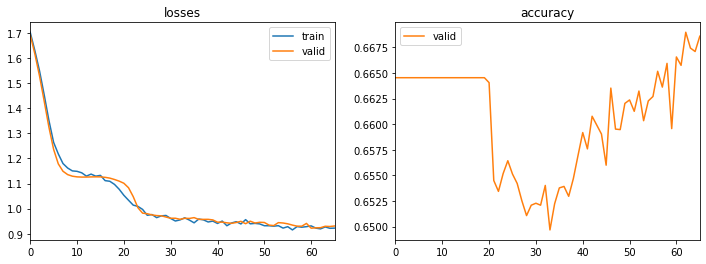

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': True, 'epochs': 10, 'hidden_size': 200, 'lr': 0.0001, 'n_layers': 1, 'optimizer': <function SGD at 0x000002305F0AA0D8>, 'patience': 5, 'time_steps': 90}
LSTM                                                                                                                   
  3%|█▌                                            | 1/30 [07:11<3:14:29, 402.40s/trial, best loss: 0.9306774735450745]

epoch,train_loss,valid_loss,accuracy,time
0,1.778875,1.775118,0.259737,00:09
1,1.768611,1.763717,0.470971,00:09
2,1.752660,1.746966,0.638869,00:09
3,1.736507,1.731013,0.660296,00:09
4,1.722745,1.717331,0.663192,00:09
5,1.712743,1.706742,0.663578,00:09
6,1.705441,1.699555,0.663964,00:09
7,1.701793,1.695545,0.664205,00:09
8,1.699983,1.693981,0.664254,00:09
9,1.698117,1.693751,0.664254,00:09


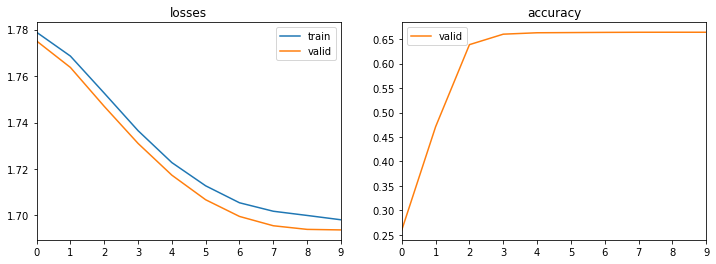

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': False, 'epochs': 10, 'hidden_size': 50, 'lr': 0.0001, 'n_layers': 3, 'optimizer': <function RMSProp at 0x000002305F0AA1F8>, 'patience': 5, 'time_steps': 90}
LSTM                                                                                                                   
  7%|███                                           | 2/30 [09:16<2:28:52, 319.00s/trial, best loss: 0.9306774735450745]

epoch,train_loss,valid_loss,accuracy,time
0,1.849807,1.839363,0.048598,00:02
1,1.497405,1.160657,0.664543,00:02
2,1.110778,1.016510,0.663288,00:02
3,0.987757,0.945197,0.663240,00:02
4,0.949288,0.939263,0.662613,00:02
5,0.926115,0.901211,0.662854,00:02
6,0.914685,0.889806,0.663144,00:02
7,0.907994,0.888465,0.663385,00:02
8,0.904572,0.889534,0.662806,00:02
9,0.903884,0.889854,0.662709,00:02


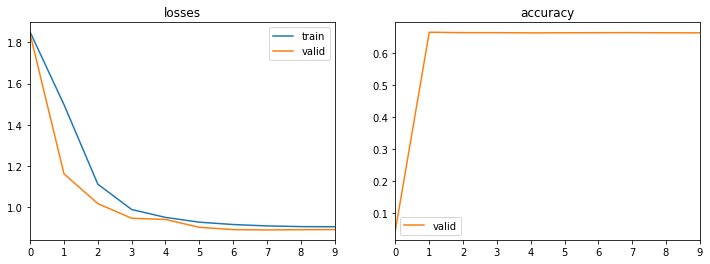

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': False, 'epochs': 10, 'hidden_size': 200, 'lr': 0.1, 'n_layers': 2, 'optimizer': <function RMSProp at 0x000002305F0AA1F8>, 'patience': 5, 'time_steps': 30}
LSTM                                                                                                                   
 10%|████▌                                         | 3/30 [10:14<1:48:18, 240.69s/trial, best loss: 0.8898538947105408]

epoch,train_loss,valid_loss,accuracy,time
0,1.341715,1.303500,0.664543,00:03
1,1.312010,1.168773,0.659669,00:03
2,1.105670,1.177147,0.636070,00:03
3,1.084276,1.199713,0.664350,00:03
4,1.053174,1.089201,0.662372,00:03
5,1.038383,1.083296,0.661020,00:03
6,1.026836,1.070081,0.659910,00:03
7,1.014026,1.065991,0.658655,00:03
8,1.017341,1.066708,0.661261,00:03
9,1.017650,1.065025,0.662468,00:03


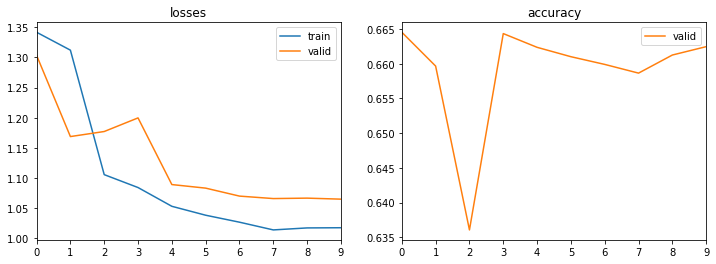

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': False, 'epochs': 10, 'hidden_size': 100, 'lr': 0.1, 'n_layers': 2, 'optimizer': <function RMSProp at 0x000002305F0AA1F8>, 'patience': 5, 'time_steps': 90}
LSTM                                                                                                                   
 13%|██████▏                                       | 4/30 [11:22<1:21:56, 189.10s/trial, best loss: 0.8898538947105408]

epoch,train_loss,valid_loss,accuracy,time
0,1.002449,1.023250,0.656484,00:04
1,1.027406,1.161339,0.664398,00:04
2,1.775644,1.478549,0.404179,00:04
3,1.630346,1.324192,0.584721,00:04
4,1.396348,1.344481,0.663916,00:04
5,1.225727,1.308834,0.663675,00:04


No improvement since epoch 0: early stopping                                                                           
 13%|██████▏                                       | 4/30 [11:49<1:21:56, 189.10s/trial, best loss: 0.8898538947105408]

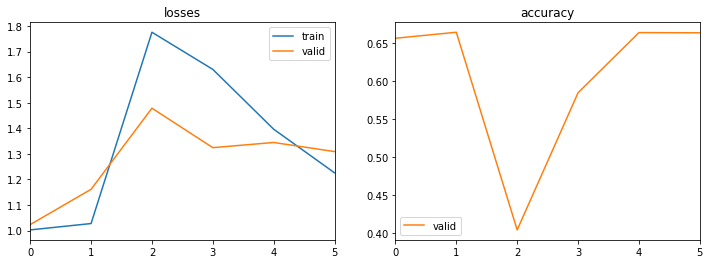

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': False, 'epochs': 50, 'hidden_size': 100, 'lr': 0.1, 'n_layers': 4, 'optimizer': <function SGD at 0x000002305F0AA0D8>, 'patience': 5, 'time_steps': 60}
LSTM                                                                                                                   
 17%|███████▋                                      | 5/30 [12:18<1:02:12, 149.28s/trial, best loss: 0.8898538947105408]

epoch,train_loss,valid_loss,accuracy,time
0,1.685626,1.619113,0.664543,00:05
1,1.499750,1.391680,0.664543,00:05
2,1.297284,1.195793,0.664543,00:05
3,1.190581,1.136155,0.664543,00:05
4,1.157235,1.127702,0.664543,00:05
5,1.144965,1.129825,0.664543,00:05
6,1.138492,1.134029,0.664543,00:05
7,1.136345,1.138306,0.664543,00:05
8,1.133896,1.140390,0.664543,00:05
9,1.134855,1.141345,0.664543,00:05


No improvement since epoch 4: early stopping                                                                           
 17%|███████▋                                      | 5/30 [13:13<1:02:12, 149.28s/trial, best loss: 0.8898538947105408]

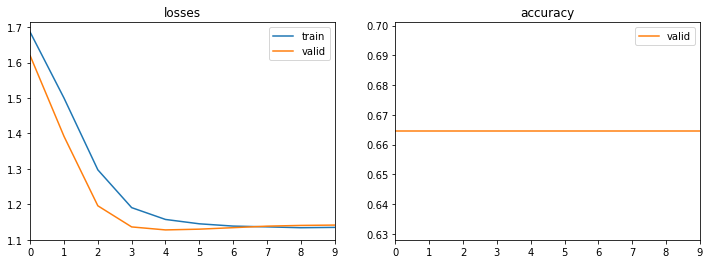

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.0001, 'n_layers': 4, 'optimizer': <function Adam at 0x000002305F0AA438>, 'patience': 5, 'time_steps': 30}
LSTM                                                                                                                   
 20%|█████████▌                                      | 6/30 [13:42<51:49, 129.58s/trial, best loss: 0.8898538947105408]

epoch,train_loss,valid_loss,accuracy,time
0,1.750099,1.743950,0.664543,00:07
1,1.719019,1.708734,0.664543,00:07
2,1.662182,1.639106,0.664543,00:07
3,1.479931,1.389122,0.664543,00:07
4,1.163169,1.120363,0.664543,00:07
5,1.098860,1.083590,0.664543,00:07
6,1.038137,1.021399,0.664543,00:07
7,1.004264,0.972092,0.664495,00:07
8,0.980496,0.956993,0.663964,00:07
9,0.967495,0.948668,0.662758,00:07


No improvement since epoch 23: early stopping                                                                          
 20%|█████████▌                                      | 6/30 [17:13<51:49, 129.58s/trial, best loss: 0.8898538947105408]

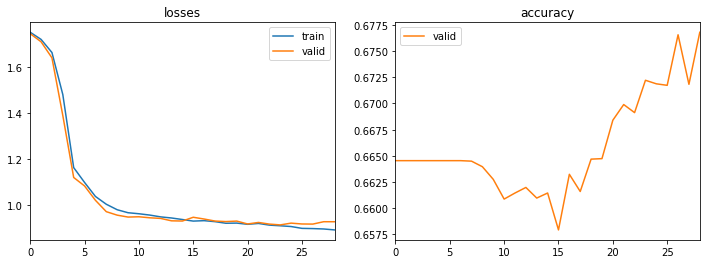

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': True, 'epochs': 100, 'hidden_size': 50, 'lr': 0.0001, 'n_layers': 2, 'optimizer': <function SGD at 0x000002305F0AA0D8>, 'patience': 5, 'time_steps': 60}
LSTM                                                                                                                   
 23%|██████████▋                                   | 7/30 [17:43<1:02:22, 162.73s/trial, best loss: 0.8898538947105408]

epoch,train_loss,valid_loss,accuracy,time
0,1.758492,1.753028,0.503354,00:05
1,1.758169,1.752199,0.519521,00:05
2,1.756250,1.751115,0.538198,00:05
3,1.755612,1.749659,0.560446,00:05
4,1.753320,1.747712,0.581632,00:05
5,1.751856,1.745174,0.605473,00:05
6,1.748155,1.741948,0.627914,00:05
7,1.744263,1.737958,0.643453,00:05
8,1.740044,1.733141,0.653202,00:05
9,1.733669,1.727450,0.658993,00:05


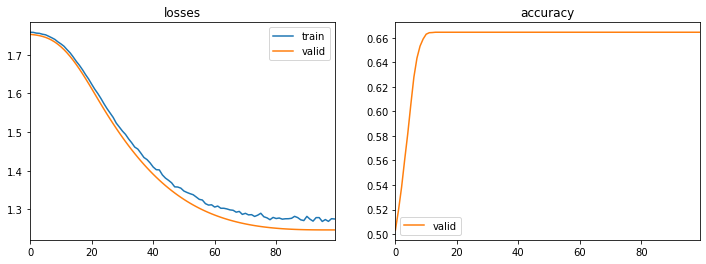

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': True, 'epochs': 50, 'hidden_size': 50, 'lr': 0.0001, 'n_layers': 4, 'optimizer': <function SGD at 0x000002305F0AA0D8>, 'patience': 5, 'time_steps': 90}
LSTM                                                                                                                   
 27%|████████████▎                                 | 8/30 [27:41<1:47:37, 293.50s/trial, best loss: 0.8898538947105408]

epoch,train_loss,valid_loss,accuracy,time
0,1.851791,1.855664,0.048598,00:08
1,1.852061,1.854911,0.048598,00:08
2,1.850683,1.853578,0.048598,00:08
3,1.849115,1.851422,0.048598,00:08
4,1.845925,1.848258,0.048598,00:08
5,1.842065,1.843969,0.048598,00:08
6,1.837402,1.838514,0.048598,00:08
7,1.830686,1.831933,0.048598,00:08
8,1.823593,1.824342,0.048598,00:08
9,1.815742,1.815922,0.048598,00:08


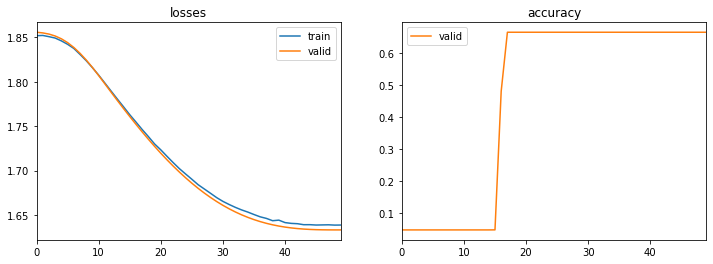

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': True, 'epochs': 50, 'hidden_size': 100, 'lr': 0.001, 'n_layers': 4, 'optimizer': <function Adam at 0x000002305F0AA438>, 'patience': 5, 'time_steps': 90}
LSTM                                                                                                                   
 30%|█████████████▊                                | 9/30 [35:23<2:00:12, 343.45s/trial, best loss: 0.8898538947105408]

epoch,train_loss,valid_loss,accuracy,time
0,1.213633,1.111494,0.664543,00:19
1,0.988212,0.931998,0.664447,00:19
2,0.904958,0.879765,0.657401,00:19
3,0.887321,0.857289,0.666184,00:19
4,0.868690,0.847886,0.681965,00:19
5,0.859824,0.843917,0.684475,00:19
6,0.853894,0.841586,0.688287,00:20
7,0.830821,0.815887,0.701704,00:19
8,0.824776,0.893328,0.684619,00:19
9,0.806008,0.830446,0.694320,00:20


No improvement since epoch 7: early stopping                                                                           
 30%|█████████████▊                                | 9/30 [39:42<2:00:12, 343.45s/trial, best loss: 0.8898538947105408]

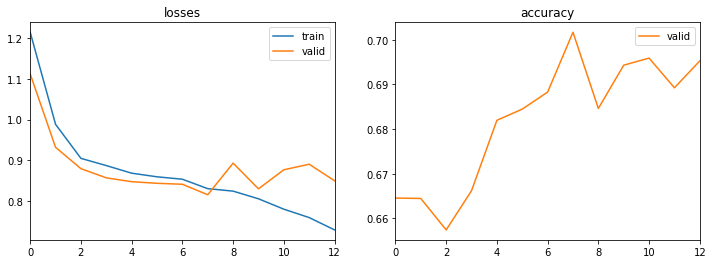

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': True, 'epochs': 50, 'hidden_size': 50, 'lr': 0.1, 'n_layers': 1, 'optimizer': <function RMSProp at 0x000002305F0AA1F8>, 'patience': 5, 'time_steps': 30}
LSTM                                                                                                                   
 33%|███████████████                              | 10/30 [40:11<1:49:10, 327.53s/trial, best loss: 0.8501006364822388]

epoch,train_loss,valid_loss,accuracy,time
0,0.942319,0.969831,0.661648,00:03
1,0.915525,1.004168,0.654071,00:03
2,0.909780,0.964115,0.675257,00:03
3,0.906810,0.976757,0.666088,00:03
4,0.924693,1.012940,0.657015,00:03
5,0.957016,0.968192,0.670190,00:03
6,0.965218,1.010027,0.656532,00:03
7,0.974458,1.000941,0.638193,00:03


No improvement since epoch 2: early stopping                                                                           
 33%|███████████████                              | 10/30 [40:39<1:49:10, 327.53s/trial, best loss: 0.8501006364822388]

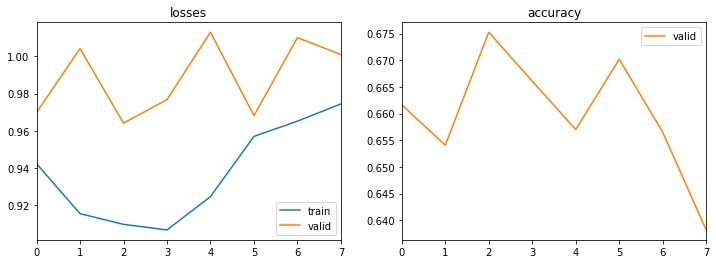

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 3, 'optimizer': <function RMSProp at 0x000002305F0AA1F8>, 'patience': 5, 'time_steps': 90}
LSTM                                                                                                                   
 37%|████████████████▌                            | 11/30 [41:05<1:18:00, 246.34s/trial, best loss: 0.8501006364822388]

epoch,train_loss,valid_loss,accuracy,time
0,1.040965,0.953019,0.662613,00:36
1,0.967740,0.905202,0.660875,00:37
2,0.948398,0.961626,0.657835,00:37
3,0.936650,0.930557,0.662902,00:37
4,0.931131,0.893682,0.672072,00:37
5,0.920045,1.005998,0.661261,00:37
6,0.916753,0.901443,0.671300,00:37
7,0.897495,0.907086,0.673423,00:37
8,0.886838,0.853844,0.678973,00:37
9,0.868723,0.816900,0.698567,00:37


No improvement since epoch 9: early stopping                                                                           
 37%|████████████████▌                            | 11/30 [50:31<1:18:00, 246.34s/trial, best loss: 0.8501006364822388]

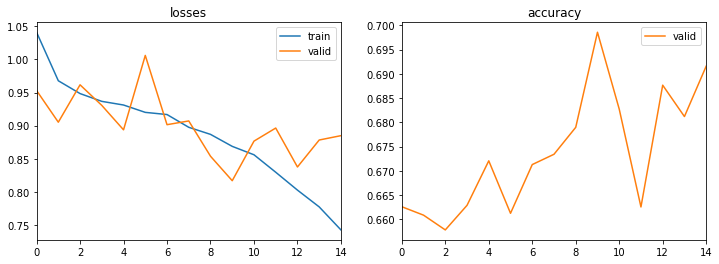

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': False, 'epochs': 50, 'hidden_size': 100, 'lr': 0.0001, 'n_layers': 5, 'optimizer': <function RMSProp at 0x000002305F0AA1F8>, 'patience': 10, 'time_steps': 30}
LSTM                                                                                                                   
 40%|██████████████████                           | 12/30 [50:56<1:44:59, 349.98s/trial, best loss: 0.8501006364822388]

epoch,train_loss,valid_loss,accuracy,time
0,1.717914,1.707837,0.664543,00:07
1,1.271353,1.156035,0.664543,00:07
2,1.067875,1.069015,0.664543,00:07
3,1.003796,0.996736,0.664543,00:07
4,0.981033,0.974588,0.664543,00:07
5,0.977227,0.961388,0.664543,00:07
6,0.972734,0.974287,0.664061,00:07
7,0.954090,0.978101,0.655422,00:07
8,0.949528,0.966681,0.652912,00:07
9,0.957261,0.954016,0.653540,00:07


No improvement since epoch 23: early stopping                                                                          
 40%|██████████████████                           | 12/30 [55:25<1:44:59, 349.98s/trial, best loss: 0.8501006364822388]

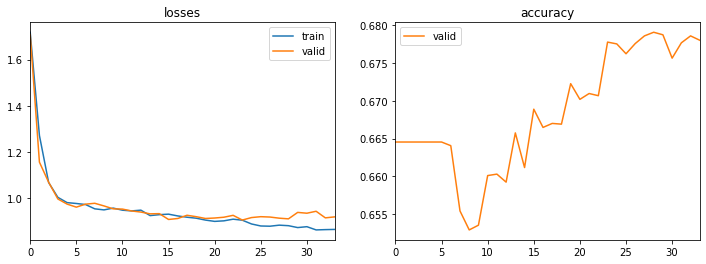

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': True, 'epochs': 100, 'hidden_size': 50, 'lr': 0.0001, 'n_layers': 4, 'optimizer': <function RMSProp at 0x000002305F0AA1F8>, 'patience': 5, 'time_steps': 60}
LSTM                                                                                                                   
 43%|███████████████████▌                         | 13/30 [55:51<1:34:24, 333.20s/trial, best loss: 0.8501006364822388]

epoch,train_loss,valid_loss,accuracy,time
0,1.782946,1.783326,0.048598,00:10
1,1.728794,1.723785,0.663578,00:10
2,1.588292,1.558137,0.664543,00:10
3,1.233894,1.188967,0.664543,00:10
4,1.128339,1.110208,0.664543,00:10
5,1.046830,1.051793,0.664350,00:10
6,0.987909,0.983396,0.663675,00:10
7,0.958339,0.934831,0.662130,00:10
8,0.935182,0.928462,0.656098,00:10
9,0.924855,0.909375,0.655760,00:10


No improvement since epoch 22: early stopping                                                                          
 43%|██████████████████▋                        | 13/30 [1:00:48<1:34:24, 333.20s/trial, best loss: 0.8501006364822388]

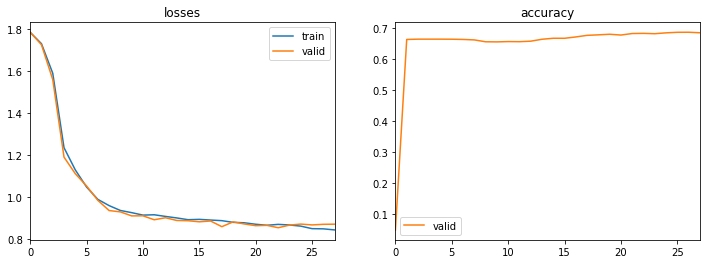

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': False, 'epochs': 50, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 5, 'optimizer': <function Adam at 0x000002305F0AA438>, 'patience': 10, 'time_steps': 60}
LSTM                                                                                                                   
 47%|████████████████████                       | 14/30 [1:01:14<1:28:01, 330.12s/trial, best loss: 0.8501006364822388]

epoch,train_loss,valid_loss,accuracy,time
0,0.960870,0.901747,0.666763,00:18
1,0.920998,0.929409,0.643309,00:19
2,0.907713,0.886938,0.680228,00:18
3,0.893990,0.834052,0.699773,00:18
4,0.863124,0.906222,0.679407,00:18
5,0.847393,0.963738,0.666474,00:18
6,0.793877,0.871637,0.694030,00:18
7,0.735756,1.002577,0.676415,00:18
8,0.680579,1.077633,0.650017,00:18
9,0.630395,1.073318,0.671879,00:19


No improvement since epoch 3: early stopping                                                                           
 47%|████████████████████                       | 14/30 [1:05:38<1:28:01, 330.12s/trial, best loss: 0.8501006364822388]

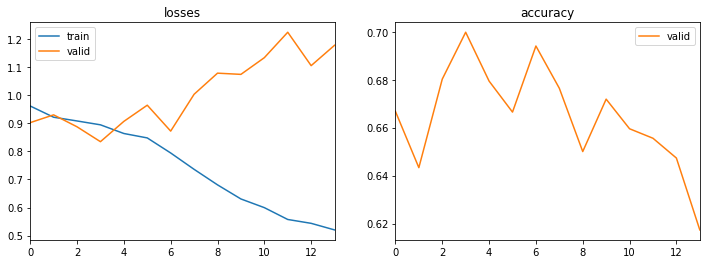

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': False, 'epochs': 100, 'hidden_size': 100, 'lr': 0.0001, 'n_layers': 1, 'optimizer': <function Adam at 0x000002305F0AA438>, 'patience': 5, 'time_steps': 30}
LSTM                                                                                                                   
 50%|█████████████████████▌                     | 15/30 [1:06:04<1:19:35, 318.34s/trial, best loss: 0.8501006364822388]

epoch,train_loss,valid_loss,accuracy,time
0,1.811630,1.812012,0.088702,00:01
1,1.802754,1.801560,0.096038,00:01
2,1.790726,1.787637,0.121664,00:01
3,1.774109,1.767913,0.189807,00:01
4,1.749406,1.738814,0.380291,00:01
5,1.712276,1.693035,0.557936,00:01
6,1.648133,1.611604,0.628155,00:01
7,1.518533,1.435922,0.651513,00:01
8,1.250804,1.155941,0.658993,00:01
9,1.130435,1.102140,0.655953,00:01


No improvement since epoch 30: early stopping                                                                          
 50%|█████████████████████▌                     | 15/30 [1:06:45<1:19:35, 318.34s/trial, best loss: 0.8501006364822388]

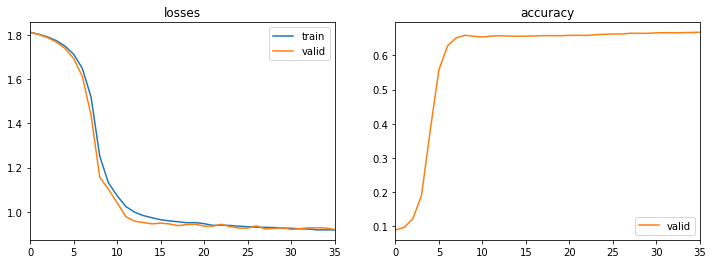

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': True, 'epochs': 50, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 5, 'optimizer': <function SGD at 0x000002305F0AA0D8>, 'patience': 10, 'time_steps': 60}
LSTM                                                                                                                   
 53%|████████████████████████                     | 16/30 [1:07:10<56:38, 242.73s/trial, best loss: 0.8501006364822388]

epoch,train_loss,valid_loss,accuracy,time
0,1.799547,1.795756,0.137879,00:06
1,1.773419,1.760628,0.137879,00:06
2,1.727185,1.701468,0.664543,00:06
3,1.654947,1.613937,0.664543,00:06
4,1.557640,1.502727,0.664543,00:06
5,1.447189,1.383361,0.664543,00:06
6,1.341722,1.278332,0.664543,00:06
7,1.260917,1.205408,0.664543,00:06
8,1.211344,1.165206,0.664543,00:06
9,1.185764,1.145965,0.664543,00:06


No improvement since epoch 15: early stopping                                                                          
 53%|████████████████████████                     | 16/30 [1:09:52<56:38, 242.73s/trial, best loss: 0.8501006364822388]

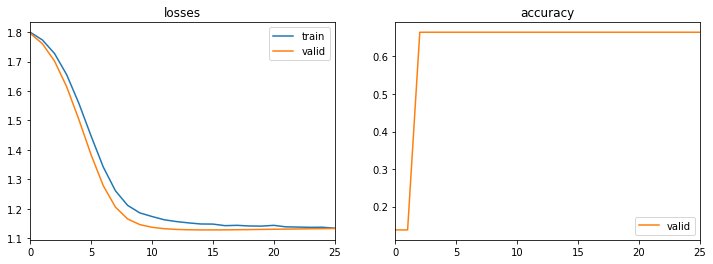

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': True, 'epochs': 10, 'hidden_size': 200, 'lr': 0.0001, 'n_layers': 2, 'optimizer': <function Adam at 0x000002305F0AA438>, 'patience': 10, 'time_steps': 60}
LSTM                                                                                                                   
 57%|█████████████████████████▌                   | 17/30 [1:10:20<48:57, 225.98s/trial, best loss: 0.8501006364822388]

epoch,train_loss,valid_loss,accuracy,time
0,1.198313,1.089373,0.661503,00:16
1,0.936652,0.905316,0.657594,00:17
2,0.903858,0.900139,0.667294,00:17
3,0.899049,0.899681,0.673375,00:17
4,0.886057,0.879728,0.682206,00:17
5,0.872579,0.864694,0.686453,00:17
6,0.864422,0.868972,0.686839,00:17
7,0.857440,0.870363,0.685681,00:17
8,0.857342,0.868682,0.687612,00:17
9,0.851754,0.866667,0.687949,00:17


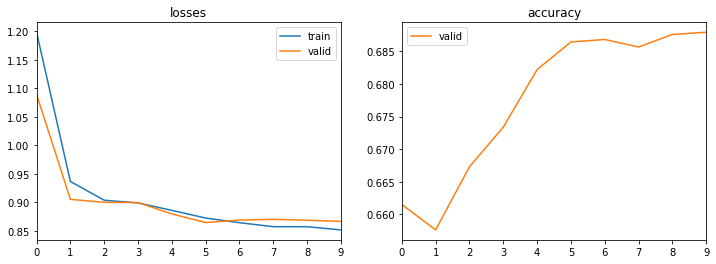

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': True, 'epochs': 10, 'hidden_size': 100, 'lr': 0.0001, 'n_layers': 4, 'optimizer': <function RMSProp at 0x000002305F0AA1F8>, 'patience': 10, 'time_steps': 60}
LSTM                                                                                                                   
 60%|███████████████████████████                  | 18/30 [1:13:39<43:44, 218.70s/trial, best loss: 0.8501006364822388]

epoch,train_loss,valid_loss,accuracy,time
0,1.412137,1.110278,0.664543,00:13
1,0.992472,0.930703,0.664205,00:13
2,0.939006,0.912226,0.656242,00:13
3,0.929031,0.916576,0.658462,00:13
4,0.910949,0.895628,0.666425,00:13
5,0.900881,0.888298,0.667342,00:13
6,0.887717,0.880855,0.672024,00:13
7,0.884105,0.872398,0.675884,00:13
8,0.877043,0.879753,0.674002,00:13
9,0.880807,0.876376,0.675016,00:13


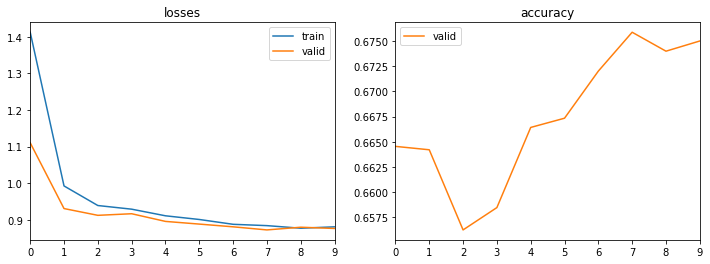

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': False, 'epochs': 10, 'hidden_size': 100, 'lr': 0.1, 'n_layers': 1, 'optimizer': <function SGD at 0x000002305F0AA0D8>, 'patience': 5, 'time_steps': 60}
LSTM                                                                                                                   
 63%|████████████████████████████▌                | 19/30 [1:16:20<36:51, 201.04s/trial, best loss: 0.8501006364822388]

epoch,train_loss,valid_loss,accuracy,time
0,1.503102,1.295487,0.664543,00:01
1,1.166882,1.106634,0.664543,00:01
2,1.081080,1.081200,0.656966,00:01
3,1.034740,1.022273,0.658511,00:01
4,1.001531,0.987003,0.648424,00:01
5,0.968857,0.940274,0.654698,00:01
6,0.950894,0.933203,0.655277,00:01
7,0.936336,0.937028,0.656098,00:01
8,0.929501,0.928861,0.657739,00:01
9,0.927554,0.926699,0.657932,00:01


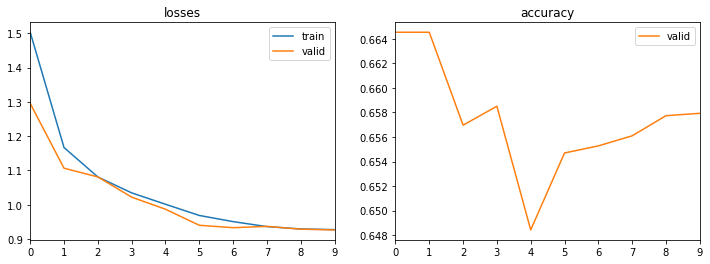

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': True, 'epochs': 10, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 2, 'optimizer': <function Adam at 0x000002305F0AA438>, 'patience': 10, 'time_steps': 90}
LSTM                                                                                                                   
 67%|██████████████████████████████               | 20/30 [1:17:04<25:40, 154.10s/trial, best loss: 0.8501006364822388]

epoch,train_loss,valid_loss,accuracy,time
0,0.933925,0.905246,0.667825,00:24
1,0.880262,0.915297,0.680566,00:24
2,0.853757,0.825743,0.695719,00:25
3,0.794849,0.817002,0.694078,00:25
4,0.727727,0.891309,0.687756,00:25
5,0.680583,0.938785,0.682448,00:25
6,0.606446,0.933214,0.694127,00:25
7,0.576244,1.039098,0.687998,00:25
8,0.526965,1.060723,0.683558,00:25
9,0.514209,1.077527,0.681386,00:25


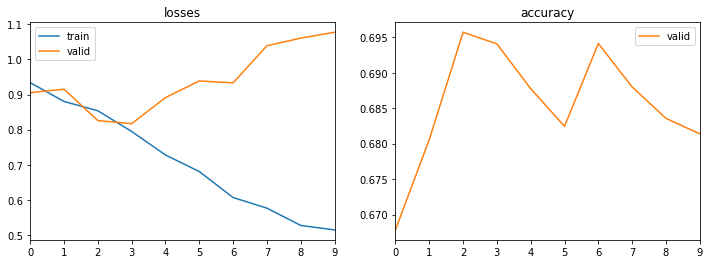

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': True, 'epochs': 10, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 2, 'optimizer': <function Adam at 0x000002305F0AA438>, 'patience': 10, 'time_steps': 90}
LSTM                                                                                                                   
 70%|███████████████████████████████▍             | 21/30 [1:21:42<28:42, 191.36s/trial, best loss: 0.8501006364822388]

epoch,train_loss,valid_loss,accuracy,time
0,1.038083,0.927200,0.665653,00:22
1,0.896147,0.877960,0.683365,00:23
2,0.868030,0.826619,0.691135,00:23
3,0.837771,0.876797,0.686019,00:23
4,0.801724,0.836411,0.694802,00:23
5,0.757702,0.842184,0.700111,00:23
6,0.727947,0.877709,0.686212,00:23
7,0.692001,0.897330,0.686695,00:23
8,0.668744,0.905287,0.682206,00:23
9,0.661483,0.911274,0.681869,00:23


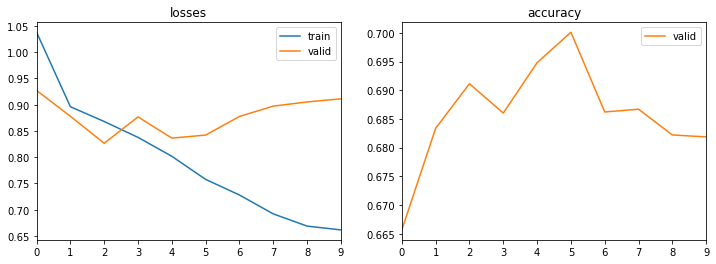

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 2, 'optimizer': <function Adam at 0x000002305F0AA438>, 'patience': 10, 'time_steps': 90}
LSTM                                                                                                                   
 73%|█████████████████████████████████            | 22/30 [1:26:02<28:17, 212.17s/trial, best loss: 0.8501006364822388]

epoch,train_loss,valid_loss,accuracy,time
0,1.156727,1.072284,0.655856,00:22
1,0.945515,0.905573,0.654071,00:23
2,0.901782,0.884345,0.667198,00:23
3,0.882068,0.860393,0.679649,00:23
4,0.884162,0.882728,0.673954,00:23
5,0.865517,0.818350,0.697312,00:23
6,0.841319,0.849297,0.685006,00:24
7,0.824173,0.839960,0.689590,00:23
8,0.804204,0.915692,0.673085,00:23
9,0.784017,0.868834,0.683461,00:23


No improvement since epoch 5: early stopping                                                                           
 73%|█████████████████████████████████            | 22/30 [1:32:20<28:17, 212.17s/trial, best loss: 0.8501006364822388]

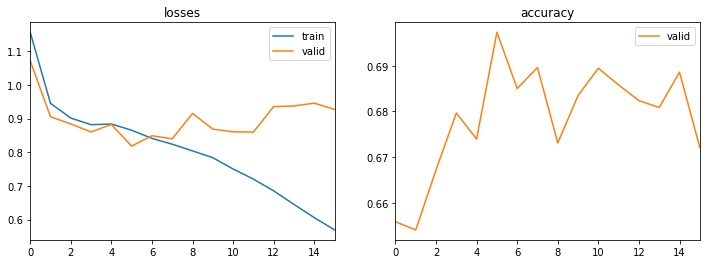

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': True, 'epochs': 10, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 4, 'optimizer': <function Adam at 0x000002305F0AA438>, 'patience': 10, 'time_steps': 60}
LSTM                                                                                                                   
 77%|██████████████████████████████████▌          | 23/30 [1:32:47<31:27, 269.63s/trial, best loss: 0.8501006364822388]

epoch,train_loss,valid_loss,accuracy,time
0,0.941595,0.933733,0.663530,00:38
1,0.917479,0.878167,0.681289,00:39
2,0.885926,0.889321,0.684282,00:39
3,0.848677,0.867303,0.688866,00:39
4,0.809986,0.928284,0.672361,00:40
5,0.757795,0.945507,0.681434,00:39
6,0.716461,0.967501,0.679407,00:39
7,0.657758,1.021900,0.671927,00:39
8,0.617645,1.061915,0.672410,00:39
9,0.608233,1.064009,0.672120,00:40


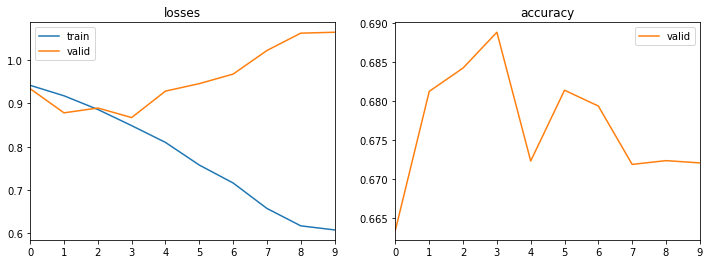

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': True, 'epochs': 50, 'hidden_size': 100, 'lr': 0.001, 'n_layers': 2, 'optimizer': <function Adam at 0x000002305F0AA438>, 'patience': 10, 'time_steps': 60}
LSTM                                                                                                                   
 80%|████████████████████████████████████         | 24/30 [1:39:53<31:35, 315.87s/trial, best loss: 0.8501006364822388]

epoch,train_loss,valid_loss,accuracy,time
0,1.078979,1.049418,0.656146,00:09
1,0.929644,0.910554,0.660489,00:09
2,0.908684,0.894162,0.668452,00:09
3,0.885997,0.914640,0.668356,00:09
4,0.881366,0.878096,0.683799,00:09
5,0.865636,0.857111,0.685488,00:09
6,0.853287,0.865598,0.685440,00:09
7,0.840024,0.881996,0.683703,00:09
8,0.824420,0.877011,0.683654,00:09
9,0.798481,0.891362,0.684571,00:09


No improvement since epoch 5: early stopping                                                                           
 80%|████████████████████████████████████         | 24/30 [1:42:23<31:35, 315.87s/trial, best loss: 0.8501006364822388]

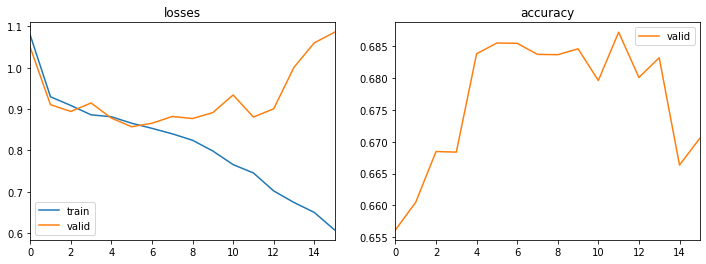

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': True, 'epochs': 50, 'hidden_size': 100, 'lr': 0.001, 'n_layers': 4, 'optimizer': <function Adam at 0x000002305F0AA438>, 'patience': 10, 'time_steps': 90}
LSTM                                                                                                                   
 83%|█████████████████████████████████████▌       | 25/30 [1:42:49<22:54, 274.80s/trial, best loss: 0.8501006364822388]

epoch,train_loss,valid_loss,accuracy,time
0,1.225086,1.105126,0.664543,00:19
1,0.990424,0.941859,0.663675,00:19
2,0.913845,0.879986,0.661744,00:19
3,0.878934,0.864993,0.672024,00:19
4,0.870908,0.853192,0.684764,00:20
5,0.858726,0.828270,0.694995,00:20
6,0.848162,0.840706,0.689349,00:20
7,0.830129,0.786105,0.696202,00:20
8,0.813233,0.850482,0.688818,00:20
9,0.802205,0.847757,0.692631,00:20


No improvement since epoch 7: early stopping                                                                           
 83%|█████████████████████████████████████▌       | 25/30 [1:48:51<22:54, 274.80s/trial, best loss: 0.8501006364822388]

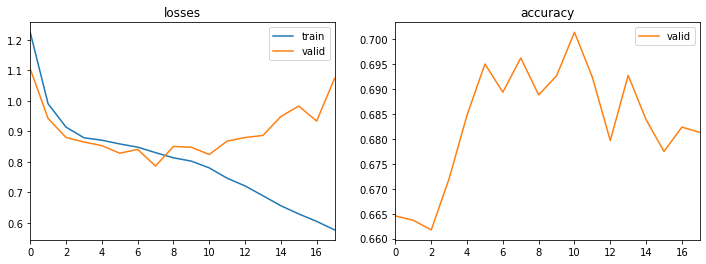

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': True, 'epochs': 10, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000002305F0AA438>, 'patience': 10, 'time_steps': 90}
LSTM                                                                                                                   
 87%|███████████████████████████████████████      | 26/30 [1:49:17<20:35, 308.79s/trial, best loss: 0.8501006364822388]

epoch,train_loss,valid_loss,accuracy,time
0,0.967247,0.941442,0.663192,00:22
1,0.928195,1.021743,0.633995,00:23
2,0.848321,0.910257,0.675981,00:23
3,0.753796,0.823708,0.703972,00:23
4,0.666734,0.913381,0.667728,00:24
5,0.581210,1.095552,0.675691,00:24
6,0.496143,1.233766,0.656484,00:23
7,0.414620,1.398589,0.660779,00:23
8,0.346585,1.561183,0.656146,00:23
9,0.302789,1.644178,0.654602,00:23


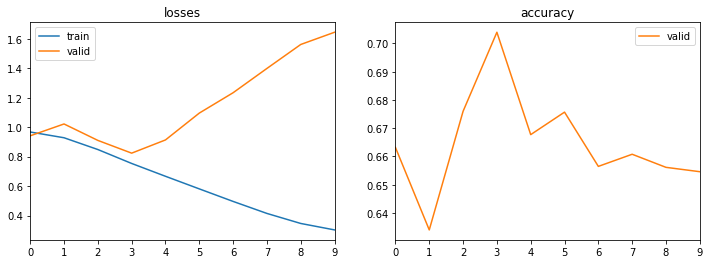

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': True, 'epochs': 10, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 4, 'optimizer': <function Adam at 0x000002305F0AA438>, 'patience': 10, 'time_steps': 60}
LSTM                                                                                                                   
 90%|████████████████████████████████████████▌    | 27/30 [1:53:41<14:44, 294.86s/trial, best loss: 0.8501006364822388]

epoch,train_loss,valid_loss,accuracy,time
0,0.943849,0.899820,0.661889,00:38
1,0.902702,0.885007,0.684909,00:39
2,0.883834,0.879291,0.684282,00:39
3,0.857253,0.863541,0.680469,00:39
4,0.808348,0.886717,0.681627,00:39
5,0.771107,0.880938,0.686984,00:40
6,0.713472,0.919212,0.693596,00:40
7,0.664122,1.007180,0.683606,00:40
8,0.632079,1.012066,0.687949,00:40
9,0.620693,1.031795,0.685054,00:39


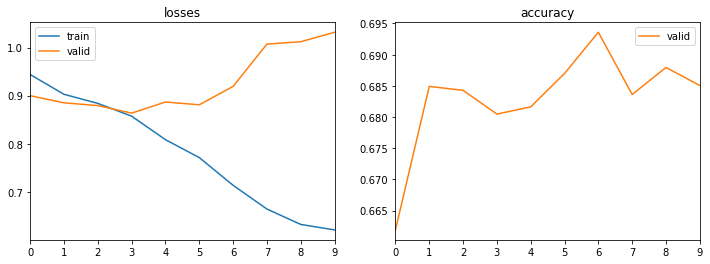

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 3, 'optimizer': <function Adam at 0x000002305F0AA438>, 'patience': 10, 'time_steps': 90}
LSTM                                                                                                                   
 93%|██████████████████████████████████████████   | 28/30 [2:00:48<11:09, 334.51s/trial, best loss: 0.8501006364822388]

epoch,train_loss,valid_loss,accuracy,time
0,0.903550,0.888286,0.674292,00:19
1,0.857994,0.881226,0.683027,00:20
2,0.849735,0.790408,0.704744,00:20
3,0.820809,0.838082,0.687708,00:20
4,0.797750,0.841347,0.688770,00:20
5,0.770209,0.893445,0.685633,00:21
6,0.721277,0.882397,0.693403,00:20
7,0.674874,0.886874,0.682206,00:21
8,0.645641,0.934839,0.654650,00:21
9,0.606922,1.018795,0.676753,00:21


No improvement since epoch 2: early stopping                                                                           
 93%|██████████████████████████████████████████   | 28/30 [2:05:19<11:09, 334.51s/trial, best loss: 0.8501006364822388]

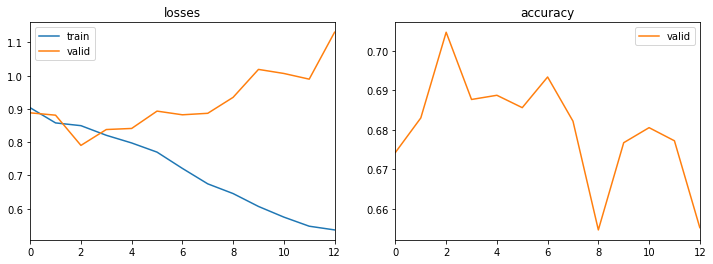

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': True, 'epochs': 50, 'hidden_size': 100, 'lr': 0.001, 'n_layers': 5, 'optimizer': <function Adam at 0x000002305F0AA438>, 'patience': 10, 'time_steps': 60}
LSTM                                                                                                                   
 97%|███████████████████████████████████████████▌ | 29/30 [2:05:48<05:23, 323.66s/trial, best loss: 0.8501006364822388]

epoch,train_loss,valid_loss,accuracy,time
0,1.223676,1.109636,0.664543,00:16
1,1.001605,0.951210,0.664543,00:17
2,0.931244,0.917091,0.662854,00:17
3,0.900451,0.887964,0.671541,00:17
4,0.893729,0.921055,0.674388,00:17
5,0.874143,0.886546,0.684619,00:17
6,0.869008,0.867728,0.688963,00:17
7,0.861693,0.865986,0.681820,00:17
8,0.848461,0.856231,0.695526,00:17
9,0.830055,0.871770,0.688577,00:17


No improvement since epoch 8: early stopping                                                                           
 97%|███████████████████████████████████████████▌ | 29/30 [2:11:16<05:23, 323.66s/trial, best loss: 0.8501006364822388]

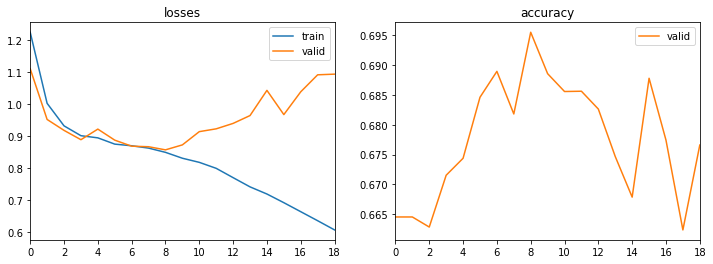

100%|█████████████████████████████████████████████| 30/30 [2:11:16<00:00, 262.55s/trial, best loss: 0.8501006364822388]


In [34]:
trials = Trials()
best = fmin(create_model_hypopt,
    space=search_space,
    algo=tpe.suggest,
    max_evals=30,  # test trials
    trials=trials)

In [35]:
print(best)

{'bidirectional': 0, 'bs': 1, 'epochs': 1, 'hidden_size': 1, 'lr': 2, 'n_layers': 3, 'optimizer': 0, 'patience': 0, 'ts': 2}


In [36]:
from hyperopt import space_eval

In [37]:
print("Best parameters:")
print(space_eval(search_space, best))

Best parameters:
{'batch_size': 512, 'bidirectional': True, 'epochs': 50, 'hidden_size': 100, 'lr': 0.001, 'n_layers': 4, 'optimizer': <function Adam at 0x000002305F0AA438>, 'patience': 5, 'time_steps': 90}


In [38]:
best_parameters = space_eval(search_space, best)

In [39]:
def build_model(params):
    # clear memory 
    gc.collect()
    print("Trying params:",params)
    batch_size = params["batch_size"]
    time_steps = params["time_steps"]
    
    # Create data loader
    tfms  = [None, [Categorize()]]
    dsets = TSDatasets(X[:, :, -time_steps:], y, tfms=tfms, splits=splits, inplace=True)
    # set num_workers for memory bottleneck
    dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)
    
    # Create model
    arch = LSTM
    k = {
        'n_layers': params['n_layers'],
        'hidden_size': params['hidden_size'],
        'bidirectional': params['bidirectional']
    }
    model = create_model(arch, dls=dls, **k)
    print(model.__class__.__name__)
    
    # Training the model
    learn = Learner(dls, model, metrics=accuracy, opt_func=params['optimizer'])
    start = time.time()
    learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                        cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
    learn.plot_metrics()
    elapsed = time.time() - start
    
    # delete tmp variables
    del dls
    del model
    return learn

Trying params: {'batch_size': 512, 'bidirectional': True, 'epochs': 50, 'hidden_size': 100, 'lr': 0.001, 'n_layers': 4, 'optimizer': <function Adam at 0x000002305F0AA438>, 'patience': 5, 'time_steps': 90}
LSTM


epoch,train_loss,valid_loss,accuracy,time
0,1.234790,1.119521,0.664543,00:19
1,0.991240,0.935764,0.663578,00:19
2,0.916780,0.883250,0.659090,00:19
3,0.884640,0.842047,0.674340,00:20
4,0.866482,0.835392,0.683606,00:20
5,0.858707,0.796591,0.699291,00:20
6,0.834851,0.787381,0.699580,00:20
7,0.823018,0.822851,0.700352,00:20
8,0.812412,0.796267,0.701221,00:20
9,0.791745,0.856510,0.693934,00:20


No improvement since epoch 6: early stopping


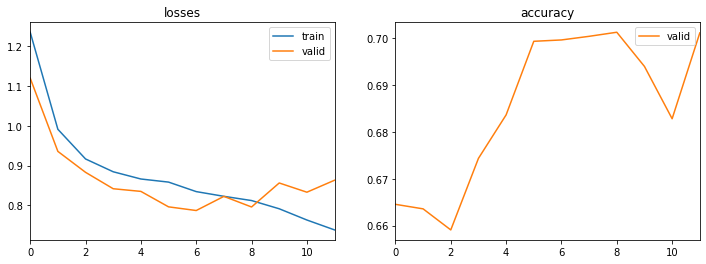

In [40]:
learn = build_model(best_parameters)

In [41]:
dls = learn.dls
valid_dl = dls.valid

In [42]:
time_steps = best_parameters["time_steps"]
X_test_tmp = X_test[:, :, -time_steps:]

In [43]:
test_ds = valid_dl.dataset.add_test(X_test_tmp, y_test)  # use the test data
test_dl = valid_dl.new(test_ds)
print(test_dl.n)

102430


In [44]:
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
test_probas, test_targets, test_preds

(tensor([[3.3335e-01, 4.6348e-01, 1.3974e-01, 5.5201e-02, 7.8851e-03, 3.3688e-04],
         [9.2359e-01, 6.5340e-02, 1.0216e-02, 8.2434e-04, 3.2468e-05, 2.3059e-06],
         [9.9584e-01, 3.7585e-03, 3.1800e-04, 7.6297e-05, 6.6180e-06, 3.4081e-07],
         ...,
         [9.9439e-01, 4.9541e-03, 5.0465e-04, 1.4202e-04, 1.2458e-05, 6.8621e-07],
         [9.9383e-01, 5.5735e-03, 5.0783e-04, 8.7024e-05, 5.0763e-06, 3.1969e-07],
         [9.6956e-01, 2.7377e-02, 2.5385e-03, 4.7216e-04, 5.0554e-05, 2.3816e-06]]),
 TensorCategory([1, 0, 0,  ..., 0, 0, 0], dtype=torch.int32),
 tensor([1, 0, 0,  ..., 0, 0, 0]))

In [45]:
print(f'accuracy: {skm.accuracy_score(test_targets, test_preds):10.6f}')
print(f'f1 score: {skm.f1_score(test_targets, test_preds, average="weighted"):10.6f}')

accuracy:   0.719799
f1 score:   0.700531


Save the true and predicted results:

In [46]:
y_test_true = test_targets.numpy()
y_test_pred = test_preds.numpy()

In [47]:
np.save('y_true_LSTM', y_test_true)
np.save('y_pred_LSTM', y_test_pred)